In [287]:
%matplotlib inline

In [288]:
#export
from exp.nb_02 import *
import torch.nn.functional as Functional

In [289]:
mathPlotLib.rcParams['image.cmap'] = 'plasma'

Data Setup
---

- Make Sure Data is normalized

In [290]:
xTraining,yTraining,xValidation,yValidation = getMnistData()

Make sure that the data is normalized, so that it has $\mu$ = 0 and $\sigma$ = 1

In [291]:
xTraining.mean(), xTraining.std()

(tensor(0.1304), tensor(0.3073))

Totally not normalized, let's fix that

In [292]:
xTrainingNormalized = normalizeVector(xTraining, xTraining.mean(), xTraining.std())

In [293]:
xTrainingNormalized.mean(), xTrainingNormalized.std()

(tensor(-7.6999e-06), tensor(1.))

# \\0/ 
Yay! Normalized!

Model Setup
---


In [294]:
rows, columns = xTrainingNormalized.shape
numberOfClasses = yTraining.max() + 1. # Largest digit to recognize :)
layerOutput = 50

In [295]:
numberOfClasses.item()

10

In [296]:
class DigitRecognitionModel(torch.nn.Module):
    def __init__(self, inputSize, numberOfClasses, layerOutput):
        super().__init__()
        self.layers = [torch.nn.Linear(inputSize, layerOutput), # Take in image vectors, output reduced matrix
                       torch.nn.ReLU(), # Perform activations
                       torch.nn.Linear(layerOutput, numberOfClasses)] # Predict digit classes.
#         self.layers = [layer.cuda() for layer in self.layers]
    def __call__(self, trainingSet):
        layerInput = trainingSet
        for layer in self.layers: layerInput = layer(layerInput)
        return layerInput

In [297]:
digitReconModel = DigitRecognitionModel(columns, numberOfClasses.item(), layerOutput)

In [298]:
digitReconModel.layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [299]:
rawPredictions = digitReconModel(xTrainingNormalized)

In [300]:
rawPredictions.shape

torch.Size([50000, 10])

In [301]:
rawPredictions

tensor([[-0.3872, -0.5327, -0.4959,  ..., -0.1437,  0.2116,  0.4025],
        [-0.2054, -0.4431, -0.3664,  ..., -0.3712,  0.2399,  0.4051],
        [ 0.1426, -0.0157,  0.1514,  ..., -0.0771,  0.2230, -0.0040],
        ...,
        [ 0.0499, -0.0287, -0.3104,  ..., -0.1593,  0.2385,  0.1238],
        [ 0.0585, -0.1225, -0.5098,  ..., -0.0896,  0.0994,  0.4788],
        [ 0.3179,  0.1188, -0.0957,  ..., -0.2139,  0.3013,  0.2271]],
       grad_fn=<AddmmBackward>)

Loss Function
---

### Predictions

Your model has to predict something so that we cat teach it something.

First, we will need to compute the softmax of our **activations**. This is defined by:

$$\hbox{softmax}(\vec{x})_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

Which inturn turns the activations from the last layer into predictions of the probablity of belonging to one of the output classes.

$\hbox{exp}(constant) = e^{constant}$


In [302]:
def softMaxLoss(predictionVector):
    return (predictionVector.exp()/predictionVector.exp().sum(-1, keepdim=True))

In [303]:
predictions = softMaxLoss(rawPredictions)

In [304]:
predictions

tensor([[0.0647, 0.0560, 0.0581,  ..., 0.0826, 0.1178, 0.1426],
        [0.0831, 0.0655, 0.0707,  ..., 0.0704, 0.1297, 0.1530],
        [0.1082, 0.0923, 0.1091,  ..., 0.0868, 0.1172, 0.0934],
        ...,
        [0.0985, 0.0911, 0.0687,  ..., 0.0799, 0.1190, 0.1061],
        [0.1013, 0.0845, 0.0574,  ..., 0.0873, 0.1055, 0.1542],
        [0.1242, 0.1018, 0.0822,  ..., 0.0730, 0.1222, 0.1134]],
       grad_fn=<DivBackward0>)

In [305]:
predictions.sum(-1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward2>)

We can see that it outputs a bunch of ones when we sum the softmax vectors together, which is expected :D

*Apparently in practice you have to take the log of soft max to get something useful*

In [306]:
predicitonsLogged = predictions.log()

In [307]:
predicitonsLogged.sum(-1)

tensor([-23.6066, -23.4864, -23.0930,  ..., -23.3039, -23.3799, -23.1664],
       grad_fn=<SumBackward2>)

## Loss
### Entropy Loss

$$ -\sum x\, \log p(x) $$


**Step One: Figure out how to get validation data**

In [308]:
yTraining[96:99]

tensor([7, 8, 3])

These are the digits that each x is supposed to represent lets see!

The 96th is supposed to be a **7**

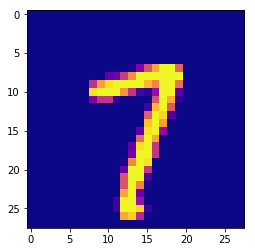

In [309]:
plotter.imshow(xTrainingNormalized[96].cpu().view(28,28))

Well would you look at that, ain't that neat?

Now let's see what our model thought how much this image looked like a **7**

In [310]:
predicitonsLogged[96][6]

tensor(-2.3281, grad_fn=<SelectBackward>)

# 🤔
Looks like it did not do a very good job, let's tell it what it needs to do to fix that

First, let's look at what our range looks like

In [311]:
predicitonsLogged[[96,97,98]]

tensor([[-2.4033, -2.1348, -2.5309, -2.2711, -2.6368, -2.1228, -2.3281, -2.4963,
         -2.2511, -2.0242],
        [-2.5394, -2.5198, -2.9830, -1.9815, -2.4293, -2.2612, -2.4765, -2.7058,
         -1.9408, -1.7998],
        [-2.2056, -2.2809, -2.6385, -2.1681, -2.4669, -2.3054, -2.0655, -2.5011,
         -2.1394, -2.3999]], grad_fn=<IndexBackward>)

Now let's remind ourselves what our expected digits are suppossed to be.

In [312]:
yTraining[96:99]

tensor([7, 8, 3])

**Combine all for profit**

In [313]:
predicitonsLogged[[96,97,98], [7,8,3]]

tensor([-2.4963, -1.9408, -2.1681], grad_fn=<IndexBackward>)

Now we can see what our model's predictions where for each of the digits. And **they are all bad**!

Let's now use this knowlege to perform

$$ -\sum x\, \log p(x) $$


In [314]:
def lossFundie(predictionVector, expectedVector): # expected vector is an array of numbers eg [4, 3, 9, 8] which correspond to each of the output classes.
    items = range(predictionVector.shape[0]) # 0 to 50000 iterator
    return -predictionVector[items, expectedVector].mean()


In [315]:
loss = lossFundie(predicitonsLogged, yTraining)

In [316]:
loss

tensor(2.3218, grad_fn=<NegBackward>)

### Enhanced LogMax!

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [317]:
def logMaxEnhanced(predictions):
    return predictions - predictions.logsumexp(-1, keepdim=True)

In [318]:
predictionsEnhanced = logMaxEnhanced(predicitonsLogged)

In [319]:
testNear(lossFundie(predictionsEnhanced, yTraining), loss)

Now that we have all of the things that we need to tell our model that it is doing a bad job. Now let's move on to teaching it how to be better. The first step there is the 

Training loop
---

In [320]:
realLossFunction = Functional.cross_entropy

In [321]:
batchSize = 64

In [322]:
#export
def accuracy(predictionVector, expectedVector):
    return (torch.argmax(predictionVector, dim=1) == expectedVector).float().mean()

In [323]:
inputBatch = xTrainingNormalized[0:batchSize]
expectedOutputBatch = yTraining[0:batchSize]

In [324]:
predictions = digitReconModel(inputBatch)

In [325]:
predictions.shape, predictions[0]

(torch.Size([64, 10]),
 tensor([-0.3872, -0.5327, -0.4959,  0.3915, -0.0376,  0.3730,  0.1169, -0.1437,
          0.2116,  0.4025], grad_fn=<SelectBackward>))

In [326]:
predictionsSoftMaxed = softMaxLoss(predictions).log()

In [327]:
# The numbers our model guessed
torch.argmax(predictionsEnhanced, dim=1)

tensor([9, 9, 8,  ..., 6, 9, 0])

In [328]:
# The largest prediction levels for each tuple.
predictionsSoftMaxed[range(0, batchSize), torch.argmax(predictionsSoftMaxed, dim=1)]

tensor([-1.9480, -1.8775, -2.1438, -2.0242, -2.0767, -1.7691, -1.9394, -1.8847,
        -1.9641, -2.0388, -2.0140, -2.0925, -2.0549, -2.0589, -2.0535, -1.9882,
        -1.7559, -1.9391, -2.1218, -2.1305, -2.0132, -1.9379, -2.1349, -2.0537,
        -1.5373, -1.7949, -2.0526, -1.9774, -1.7432, -2.0310, -2.0379, -1.7661,
        -1.8911, -1.9774, -1.8800, -2.0218, -1.9286, -1.9246, -1.9899, -1.8869,
        -2.1555, -1.8745, -2.0541, -2.0687, -2.0345, -1.8872, -2.0867, -1.9217,
        -2.0325, -1.9956, -1.9493, -1.9070, -2.0198, -2.0715, -1.9224, -1.9747,
        -1.9991, -2.1033, -1.9085, -2.0083, -2.1535, -1.9370, -2.0715, -1.9119],
       grad_fn=<IndexBackward>)

In [341]:
accuracy(predictions, expectedOutputBatch)

tensor(0.1250)

About as good as random guessing.

# How to train a model

In [332]:
learningRate = 0.5
epochs = 1

### Get ready to train!

In [334]:
for epoch in range(epochs):
    for i in range((rows//batchSize + 1)): # Process each of the batches
        beginningRange = i * batchSize
        endingRange = beginningRange + batchSize
        _inputBatch = xTrainingNormalized[beginningRange:endingRange]
        validationBatch = yTraining[beginningRange:endingRange]
        preds = digitReconModel(_inputBatch)
        loss = realLossFunction(preds, validationBatch)
        
        loss.backward()
        
        with torch.no_grad():
            for layer in digitReconModel.layers:
                if hasattr(layer, 'weight'):
                    layer.weight -= layer.weight.grad * learningRate
                    layer.bias -= layer.bias.grad * learningRate
                    layer.weight.grad.zero_()
                    layer.bias.grad.zero_()


In [337]:
torch.argmax(digitReconModel(inputBatch), dim=1)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 3, 4, 3, 7, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        5, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [338]:
expectedOutputBatch

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [340]:
accuracy(digitReconModel(xTrainingNormalized[69:100]), yTraining[69:100])

tensor(0.9355)

Yay! Higher accuracy rates!

**Moving on to refactoring the model to have that enhancement**

In [378]:
class EnhancedDigitModel(torch.nn.Module): 
    def __init__(self, inputSize, numberHiddenLayers, classes, learningRate):
        super().__init__()
        self.layerOne = torch.nn.Linear(inputSize, numberHiddenLayers)
        self.layerTwo = torch.nn.Linear(numberHiddenLayers, classes)
        self.learningRate = learningRate
        
    def __call__(self, inputMatrix): return self.layerTwo(Functional.relu(self.layerOne(inputMatrix)))
    
    def zeroOutGradients(self):
        for layerParameter in self.parameters : layerParameter.grad.data.zero_()
    
    def step(self):
        with torch.no_grad():
            for layerParameter in self.parameters : layerParameter -= layerParameter.grad * self.learningRate
    
    def learn(self):
        self.zeroOutGradients()

In [353]:
enhancedDigitModel = EnhancedDigitModel(columns, layerOutput, numberOfClasses.item())

In [355]:
predictions = enhancedDigitModel(inputBatch)

In [358]:
torch.argmax(predictions, dim=1)

tensor([2, 8, 0, 2, 8, 8, 2, 2, 8, 2, 2, 2, 2, 6, 8, 2, 6, 2, 3, 2, 2, 2, 2, 2,
        2, 8, 8, 2, 2, 8, 2, 2, 6, 2, 8, 2, 2, 8, 8, 8, 8, 8, 8, 2, 2, 8, 2, 8,
        9, 2, 6, 2, 8, 3, 2, 2, 8, 8, 2, 2, 8, 8, 3, 2])

In [359]:
expectedOutputBatch

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [361]:
accuracy(predictions, expectedOutputBatch)

tensor(0.0781)

not very good.

In [363]:
enhancedDigitModel

EnhancedDigitModel(
  (layerOne): Linear(in_features=784, out_features=50, bias=True)
  (layerTwo): Linear(in_features=50, out_features=10, bias=True)
)

In [369]:
for epoch in range(epochs):
    for i in range((rows//batchSize + 1)): # Process each of the batches
        beginningRange = i * batchSize
        endingRange = beginningRange + batchSize
        _inputBatch = xTrainingNormalized[beginningRange:endingRange]
        validationBatch = yTraining[beginningRange:endingRange]
        preds = enhancedDigitModel(_inputBatch)
        loss = realLossFunction(preds, validationBatch)
        
        loss.backward()
        
        with torch.no_grad():
            for layerParameter in enhancedDigitModel.parameters(): 
                layerParameter -= layerParameter.grad * learningRate
            enhancedDigitModel.zero_grad() # method inherited from the nn.Module

In [370]:
accuracy(enhancedDigitModel(inputBatch), expectedOutputBatch)

tensor(0.9375)

Better!

In [395]:
class SelfLearningModel(torch.nn.Module): 
    def __init__(self, inputSize, numberHiddenLayers, classes, learningRate):
        super().__init__()
        self.layerOne = torch.nn.Linear(inputSize, numberHiddenLayers)
        self.layerTwo = torch.nn.Linear(numberHiddenLayers, classes)
        self.learningRate = learningRate
        
    def __call__(self, inputMatrix): return self.layerTwo(Functional.relu(self.layerOne(inputMatrix)))
    
    def zeroOutGradients(self):
        for layerParameter in self.parameters() : layerParameter.grad.data.zero_()
    
    def step(self):
        with torch.no_grad():
            for layerParameter in self.parameters() : layerParameter -= layerParameter.grad * self.learningRate
    
    def learn(self):
        self.step()
        self.zeroOutGradients()

In [379]:
def batchData(iteration):
    beginningRange = iteration * batchSize
    endingRange = beginningRange + batchSize
    _inputBatch = xTrainingNormalized[beginningRange:endingRange]
    validationBatch = yTraining[beginningRange:endingRange]
    return _inputBatch, validationBatch

In [465]:
def trainModel(learningModel):
    for epoch in range(epochs):
        for i in range((rows)//batchSize + 1):
            _inputBatch, _expectedBatch = batchData(i)
            _predictions = learningModel(_inputBatch)
            loss = realLossFunction(_predictions, _expectedBatch)

            loss.backward()

            learningModel.learn()

In [396]:
selfLearner = SelfLearningModel(columns, layerOutput, numberOfClasses.item(), learningRate)

In [397]:
accuracy(selfLearner(inputBatch), expectedOutputBatch)

tensor(0.0938)

In [398]:
trainModel(selfLearner)

In [404]:
newPred = selfLearner(inputBatch)
accuracy(newPred, expectedOutputBatch)

tensor(0.8281)

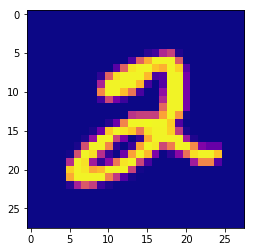

In [451]:
plotter.imshow(inputBatch[5].view(28,28))

In [452]:
torch.argmax(newPred[5])

tensor(2)

In [410]:
#export
from torch import optim

In [411]:
class SelfLearningLibraryModel(torch.nn.Module): 
    def __init__(self, inputSize, numberHiddenLayers, classes, learningRate):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(inputSize, numberHiddenLayers),
            torch.nn.ReLU(),
            torch.nn.Linear(numberHiddenLayers, classes)
        )
        self.optimizer = optim.SGD(self.parameters(), learningRate)
        
    def __call__(self, inputMatrix): return self.layers(inputMatrix)
    
    def learn(self):
        self.optimizer.step()
        self.optimizer.zero_grad()

In [412]:
librarySelfLearner = SelfLearningLibraryModel(columns, layerOutput, numberOfClasses.item(), learningRate)

In [413]:
libraryPreds = librarySelfLearner(inputBatch)

In [414]:
accuracy(libraryPreds, expectedOutputBatch)

tensor(0.0156)

In [425]:
trainModel(librarySelfLearner)

In [426]:
accuracy(librarySelfLearner(inputBatch), expectedOutputBatch)

tensor(0.9531)

# Datasets!


In [428]:
#export
class Dataset:
    def __init__(self, xVector, yVector):
        self.xVector = xVector
        self.yVector = yVector
    def __len__(self): return len(self.xVector)
    def __getitem__(self, i): return self.xVector[i],self.yVector[i]

In [429]:
xValidationNormalized = normalizeVector(xValidation, xValidation.mean(), xValidation.std())

In [430]:
trainingDataset, validationDataSet = Dataset(xTrainingNormalized, yTraining), Dataset(xValidation, yValidation)

In [433]:
trainingDataset[2][1]

tensor(4)

In [437]:
assert len(trainingDataset) == len(xTrainingNormalized)
assert len(validationDataSet) == len(xValidationNormalized)

In [443]:
xData, yData = trainingDataset[0:5]

In [447]:
assert xData.shape == (5, 28*28)
assert yData.shape == (5,)

In [457]:
class DataLoader:
    def __init__(self, dataSet, batchSize):
        self.dataSet = dataSet
        self.batchSize = batchSize
    def __iter__(self):
        for i in range(0, len(self.dataSet), self.batchSize): yield self.dataSet[i:i+self.batchSize]

In [620]:
def trainModelEnhanced(learnableModel, dataLoader, validationDataLoader):
    for epoch in range(epochs):
        for _xTrain, _yTrain in dataLoader:
            _preds = learnableModel(_xTrain)
            loss = realLossFunction(_preds, _yTrain)
            loss.backward()
            learnableModel.learn()

In [466]:
modelToTeach = SelfLearningLibraryModel(columns, layerOutput, numberOfClasses.item(), learningRate)

In [467]:
accuracy(modelToTeach(inputBatch), expectedOutputBatch)

tensor(0.0625)

In [470]:
trainModelEnhanced(modelToTeach, DataLoader(trainingDataset, batchSize))

In [471]:
accuracy(modelToTeach(inputBatch), expectedOutputBatch)

tensor(0.9062)

In [477]:
accuracy(modelToTeach(xValidationNormalized), yValidation)

tensor(0.8933)

## Random Sampling

The enhanced data loader that shuffles the data (and also keeps the labels correct)

In [485]:
class RandomSampler:
    def __init__(self, numberOfItems, batchSize, shuffle=True):
        self.numberOfItems, self.batchSize, self.shuffle = numberOfItems, batchSize, shuffle
        
    def __iter__(self):
        self.shuffledIndices = torch.randperm(self.numberOfItems) if self.shuffle else torch.arange(self.numberOfItems)
        for batch in range(0, self.numberOfItems, self.batchSize): yield self.shuffledIndices[batch: batch + self.batchSize]
            
            

In [486]:
rando = RandomSampler(8, 2)
[batch for batch in rando]

[tensor([3, 0]), tensor([6, 2]), tensor([1, 4]), tensor([5, 7])]

In [489]:
rando = RandomSampler(9, 2, False)
[batch for batch in rando]

[tensor([0, 1]), tensor([2, 3]), tensor([4, 5]), tensor([6, 7]), tensor([8])]

In [495]:
things = [
    "One",
    "Two",
    "Three",
    "Four",
    "Five",
    "Six",
    "Seven",
    "Eight",
    "Nine"
]

In [510]:
rando = RandomSampler(8, 2)
[ list(map(lambda i: things[i], _batch)) for _batch in rando]

[['Two', 'Four'], ['Six', 'Eight'], ['Seven', 'One'], ['Five', 'Three']]

In [599]:
def collateTuple(tupl):
    xColumn, yColumn = zip(*tupl)
    return torch.stack(xColumn), torch.stack(yColumn)

In [576]:
class EnhancedDataLoader:
    def __init__(self, dataSet, batchSize):
        self.dataSet = dataSet
        self.batchSize = batchSize
        self.sampler = RandomSampler(len(dataSet), batchSize)
    def __iter__(self):
        for _batch in self.sampler: yield collateTuple([ self.dataSet[_index] for _index in _batch])

In [577]:
testLoader = EnhancedDataLoader(things, 2)

In [600]:
for _thing in testLoader: print(_thing)

ValueError: too many values to unpack (expected 2)

In [585]:
anotherTestLoader = EnhancedDataLoader(Dataset(inputBatch, expectedOutputBatch), 10)

In [605]:
for _thing in anotherTestLoader: 
    a, b =_thing 
    print((len(a), len(b)))

(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(4, 4)


In [607]:
newDigitModel = SelfLearningLibraryModel(columns, layerOutput, numberOfClasses.item(), learningRate)

In [608]:
accuracy(newDigitModel(inputBatch), expectedOutputBatch)

tensor(0.0625)

In [609]:
trainModelEnhanced(newDigitModel, EnhancedDataLoader(Dataset(xTrainingNormalized, yTraining), 75))

In [612]:
accuracy(newDigitModel(inputBatch), expectedOutputBatch)

tensor(0.9375)

## Libraries Data Stuff ._.

In [611]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [613]:
brandNewDigitModel = SelfLearningLibraryModel(columns, layerOutput, numberOfClasses.item(), learningRate)

In [614]:
accuracy(brandNewDigitModel(inputBatch), expectedOutputBatch)

tensor(0.0469)

In [617]:
trainModelEnhanced(brandNewDigitModel, DataLoader(collate_fn=collateTuple, 
                                                  dataset=Dataset(xTrainingNormalized, yTraining), 
                                                  batch_size=75,
                                                  shuffle=True))

In [618]:
accuracy(brandNewDigitModel(inputBatch), expectedOutputBatch)

tensor(0.9531)

In [619]:
accuracy(brandNewDigitModel(xValidationNormalized), yValidation)

tensor(0.9445)

## Better Validation


In [635]:
def trainModelWithValidation(learnableModel, dataLoader, validationDataLoader, epochs):
    for epoch in range(epochs):
        for _xTrain, _yTrain in dataLoader:
            _preds = learnableModel(_xTrain)
            loss = realLossFunction(_preds, _yTrain)
            loss.backward()
            learnableModel.learn()
        accumulatedLoss, accumulatedAccuracy = 0.,0.
        for _xValidation, _yValidation in validationDataLoader:
            with torch.no_grad(): # do not produce gradients when running loss function
                _preds = learnableModel(_xValidation)
                accumulatedLoss += realLossFunction(_preds, _yValidation)
                accumulatedAccuracy += accuracy(_preds, _yValidation)
        numberOfItems = len(validationDataLoader)
        print("Epoch {}, Accuracy {}, Loss {}".format(epoch, accumulatedAccuracy/numberOfItems, accumulatedLoss/numberOfItems))

In [636]:
fancyDigitModel = SelfLearningLibraryModel(columns, layerOutput, numberOfClasses.item(), learningRate)

In [637]:
accuracy(fancyDigitModel(inputBatch), expectedOutputBatch)

tensor(0.1250)

In [638]:
trainModelWithValidation(fancyDigitModel, 
                         DataLoader(collate_fn=collateTuple, 
                                                  dataset=Dataset(xTrainingNormalized, yTraining), 
                                                  batch_size=75,
                                                  shuffle=True), 
                         DataLoader(collate_fn=collateTuple, 
                                                  dataset=Dataset(xValidationNormalized, yValidation), 
                                                  batch_size=75), 
                         5)

Epoch 0, Accuracy 0.9192036390304565, Loss 0.2772819995880127
Epoch 1, Accuracy 0.9257708191871643, Loss 0.28181517124176025
Epoch 2, Accuracy 0.9156214594841003, Loss 0.30584725737571716
Epoch 3, Accuracy 0.9494523406028748, Loss 0.18209196627140045
Epoch 4, Accuracy 0.9541289210319519, Loss 0.1749899834394455


In [634]:
accuracy(fancyDigitModel(xValidationNormalized), yValidation)

tensor(0.9505)

In [640]:
#export
def createDataLoaders(trainingDataSet, validationDataSet, batchSize, **kwargs):
    return (
        DataLoader(trainingDataSet, batch_size=batchSize, shuffle=True, **kwargs),
        DataLoader(validationDataSet, batch_size=batchSize*2, **kwargs)
    )

In [655]:
testDigitModel = SelfLearningLibraryModel(columns, layerOutput, numberOfClasses.item(), learningRate)

In [656]:
trainingDataLoader, validationDataLoader = createDataLoaders(Dataset(xTrainingNormalized, yTraining), 
                                                             Dataset(xValidationNormalized, yValidation), 
                                                             batchSize, 
                                                             collate_fn=collateTuple)

In [657]:
accuracy(testDigitModel(xValidationNormalized), yValidation)

tensor(0.0997)

In [658]:
trainModelWithValidation(testDigitModel, trainingDataLoader, validationDataLoader, 7)

Epoch 0, Accuracy 0.8950751423835754, Loss 0.4031490981578827
Epoch 1, Accuracy 0.804094135761261, Loss 0.8487293124198914
Epoch 2, Accuracy 0.9528283476829529, Loss 0.1820055991411209
Epoch 3, Accuracy 0.8481012582778931, Loss 1.1656832695007324
Epoch 4, Accuracy 0.9336432218551636, Loss 0.32268327474594116
Epoch 5, Accuracy 0.9587618708610535, Loss 0.18828605115413666
Epoch 6, Accuracy 0.962717592716217, Loss 0.15694169700145721


In [659]:
accuracy(testDigitModel(xValidationNormalized), yValidation)

tensor(0.9623)

In [663]:
!python notebook2script.py 03_MINI_BATCH_FROM_SCRATCH.ipynb

Traceback (most recent call last):
  File "notebook2script.py", line 3, in <module>
    import json,fire,re
ModuleNotFoundError: No module named 'fire'
